In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.1


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [4]:
data_file = np.load('./public_data.npz', allow_pickle=True)

In [5]:
data = data_file["data"]
labels = data_file["labels"]

In [6]:
data.shape, labels.shape

((5200, 96, 96, 3), (5200,))

In [7]:
data[0].dtype

dtype('float32')

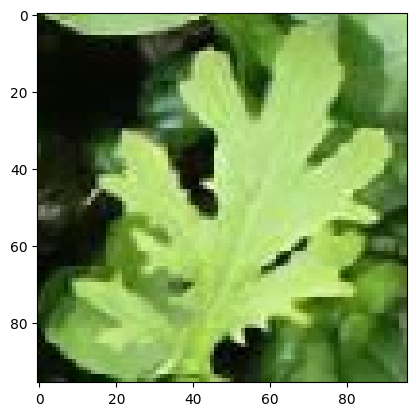

In [8]:
plt.figure()
plt.imshow(data[0] / 255.0) 
plt.show()  # display it

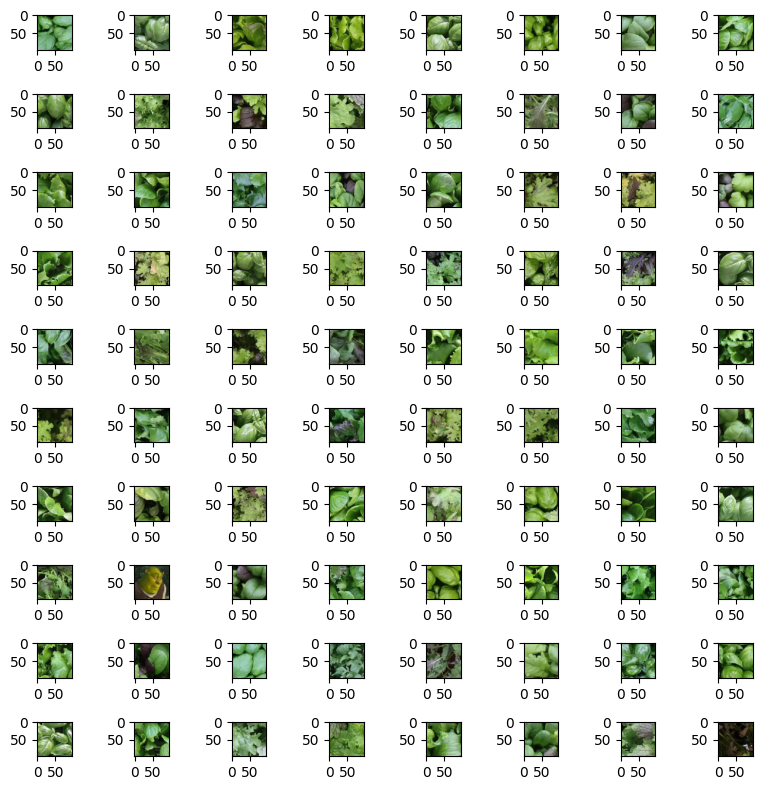

In [9]:
w = 10
h = 10
columns = 8
rows = 10

# Create subplots for displaying items
fig = plt.figure(figsize=(8, 8))
for i in range(1, columns*rows +1):
    img = data[i] / 255.0
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.tight_layout()
plt.show()

In [18]:
# Resizing
resizing = tfk.Sequential([
    tfkl.experimental.preprocessing.Resizing(224, 224)
])

X_train_resized = resizing(data)

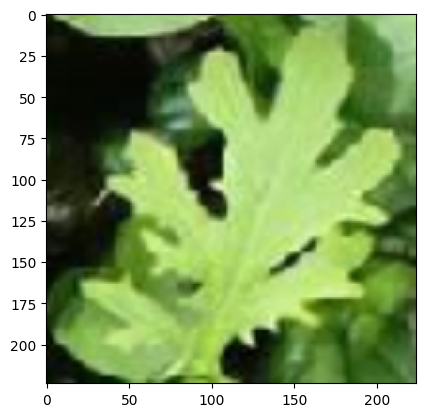

In [20]:
w = 10
h = 10
columns = 8
rows = 10

plt.imshow(X_train_resized[0] / 255.0)
plt.show()

In [11]:
#Healthy: 3199,
#Unhealthy: 2001
np.unique(labels, return_counts=True)
y = labels
y[y=="healthy"] = 0
y[y=="unhealthy"] = 1

y = tfk.utils.to_categorical(y, num_classes=2)
y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [12]:
X = data
X = X / 255.0
X.shape

(5200, 96, 96, 3)

In [13]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.2, stratify=np.argmax(y,axis=1))
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=np.argmax(y_train_val,axis=1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (3744, 96, 96, 3), y_train shape: (3744, 2)
X_test shape: (1040, 96, 96, 3), y_test shape: (1040, 2)
X_val shape: (416, 96, 96, 3), y_val shape: (416, 2)


In [15]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
#tfk.utils.plot_model(mobile, show_shapes=True)

In [21]:
mobile.trainable = False

inputs = tfk.Input(shape=(224, 224, 3))
x = mobile(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [22]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(resizing(X_train)*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (preprocess_input(resizing(X_val)*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/100
234/234 [==============================] - 74s 300ms/step - loss: 0.5527 - accuracy: 0.7265 - val_loss: 0.4457 - val_accuracy: 0.7861
Epoch 2/100
234/234 [==============================] - 69s 294ms/step - loss: 0.4293 - accuracy: 0.8040 - val_loss: 0.4356 - val_accuracy: 0.7861
Epoch 3/100
234/234 [==============================] - 71s 305ms/step - loss: 0.3921 - accuracy: 0.8304 - val_loss: 0.4136 - val_accuracy: 0.7957
Epoch 4/100
234/234 [==============================] - 68s 289ms/step - loss: 0.3624 - accuracy: 0.8451 - val_loss: 0.4386 - val_accuracy: 0.7957
Epoch 5/100
234/234 [==============================] - 64s 272ms/step - loss: 0.3443 - accuracy: 0.8480 - val_loss: 0.4244 - val_accuracy: 0.7909
Epoch 6/100
234/234 [==============================] - 62s 266ms/step - loss: 0.3387 - accuracy: 0.8582 - val_loss: 0.4030 - val_accuracy: 0.7957
Epoch 7/100
234/234 [==============================] - 65s 277ms/step - loss: 0.3174 - accuracy: 0.8662 - val_loss: 0.4144 -

In [23]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model